/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_53139/2008824684.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD)
[*********************100%***********************]  1 of 1 completed


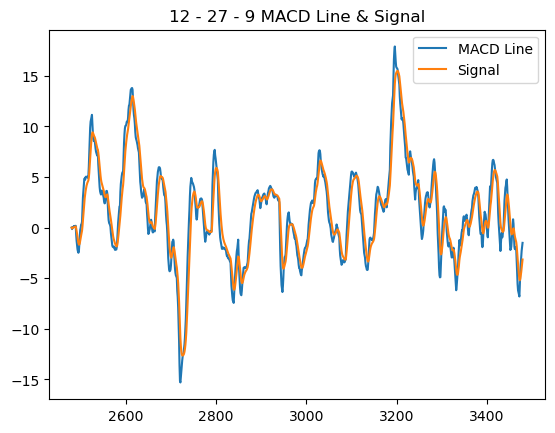

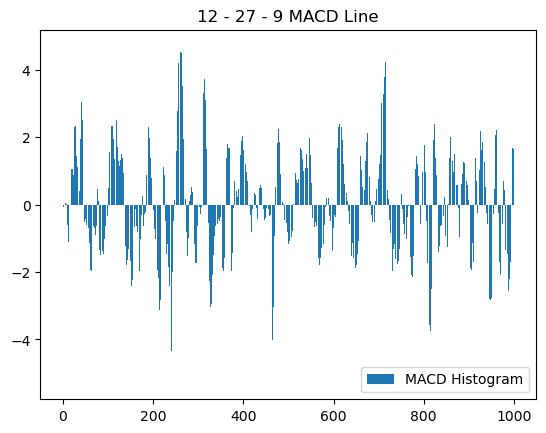

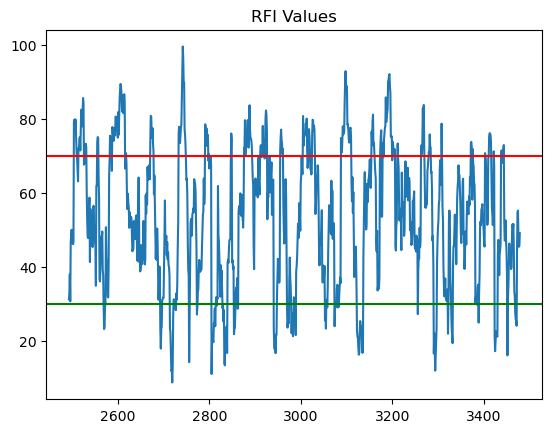

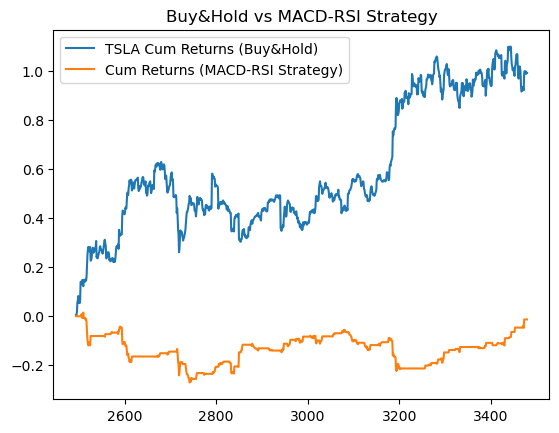

In [ ]:
import yfinance as yf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

TICKER = "TSLA"

# Price Behavior does not change much based on Interval,
    # but we can switch between Minute/Hourly/Daily Data
INTERVAL = "1h" 
# Set Period based on interval
if INTERVAL == "1h":
    PERIOD == "730d"
else:
    PERIOD = "max"

# MACD is used to explain Trends
    # when the signal line crosses above the MACD line - Bullish Momentum
    # when the signal line crosses below the MACD line - Bearish Momentum
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# RSI is used to enter or exit trades or shift in momentum. It ossilating 0-100:
    # When it reaches 70 - it is overbrought, so it will come down soon
    # When it reaches 30 - it is oversold, so it will come up soon
RSI_LENGTH = 14
OVERBROUGHT = 70
OVERSOLD = 30

# Subsection of the data we are interested on
LOOKBACK = 1000


def get_data(ticker = TICKER, lookback = LOOKBACK, interval = INTERVAL):

    # Get Data at Interval you want
    df = yf.download(ticker, interval = interval, period = PERIOD)
    df.columns = df.columns.get_level_values(0)

    # Solving for Plot Gaps:
        # Correcting our Graph, by removing "Empty Dates" with no price data
        # To do that, we change the x-Achsis to a Number Index
        # We will still get Gaps, but not Diagonal Lines, because the Index
        # is not accounting for Instances where the Market is Closed 
    df = df.reset_index(drop=True)

    # Only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):
    
        # Step 1: Create Fast and Slow EMA Columns
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

        # Step 2: Create MACD Column (Macd line is the difference between the fast and the slow)
    df[f"MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

        # Step 3: Create MACD Signal Column (Span here = 9-period) == moving average of this line
    df["Signal"] = df[f"MACD"].ewm(span=span).mean()

        # Step 4: MACD Hist is almost always what is used fin TA
    df["MACD_HIST"] = df[f"MACD"] - df[f"Signal"]

        # Step 5: Plot Functions
    plt.figure()
    plt.plot(df["MACD"]) # Blue
    plt.plot(df["Signal"]) # Orange
        # When MACD (Blue Line) crosses above the Signal (Orange line) == Upwards momentum (Long)
        # When MACD (Blue Line) crosses below the Signal (Orange line) == Downwards momentum (Short)
    plt.title(f"{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Line & Signal")
    plt.legend(["MACD Line", "Signal"])

        # Step 6: Plot Histogram 
    plt.figure()
    # Histogram Strategy (Crossover == Signal to Enter) - Plot a bar Chart:
        # Previous Version: 
    # plt.bar(x=df.index, height=df["MACD_HIST"])
        # Current Version
    plt.bar(x=range(len(df)), height=df["MACD_HIST"])
    # "For every Date in my index, draw a bar equal to that day's Histogram Value 
    # Direction: is the bar positive (above 0 - Bullish) or negative (below 0 - Bearish)?
    # Strength: is the bar tall (strong momentum) or short (weak momentum)?
    plt.title(f"{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Line")
    plt.legend(["MACD Histogram"])

    return df

def add_RSI(df, length = RSI_LENGTH):
        # Step 1: Define Delta (== Change in Prices from One Day to the next)
    price_change = df["Close"].diff()
    # Debug/Print Code: print(df["Close"].head(5))
    # Debug/Print Code: print(price_change[:5])
    # This inbuilt diff function shows the difference between the rows 

        # Step 2: We group Price Changes based on Pos/Neg Returns
    df["gain"] = price_change.where(price_change > 0, 0)
    df["loss"] = - price_change.where(price_change < 0, 0)
    # Start with the price_changes Series
    # Keep the original values, whereever (price_change > 0) is true
    # Replace the original values with 0, whereever (price_change > 0) is False 

        # Step 3: "Rolling" means to take the MA of the RSI_LENGTH (a number of days)   
    df["avg_gain"] = df["gain"].rolling(window=length).mean()
    df["avg_loss"] = df["loss"].rolling(window=length).mean()

        # Step 4: Calculate the Relative Strength  
    # What percentage of each other have the gains and losses been?
    # "What percentage of the average loss is the average gain?"
    # "How much stronger have the Up Days been compared to the Down days"
    rs = df["avg_gain"] / df["avg_loss"]
    # if rs = 3. Then the average gain was 3x larger than the average loss --> Shows strong Upward Momentum 
    # if rs = 0.5. Then the average gain was half the size of the average loss --> Shows strong Downward momentum

        # Step 5: Calculate the RSI (Standardization - Keep values between 0-100)
    # If rs is 1, then we get to 50. Which is the perfect midpoint. 
    df["RSI"] = 100 - (100/ (1+rs))

        # Step 6: Plot the RSI 
    plt.figure()
    plt.plot(df["RSI"])
    plt.title("RFI Values")

    # Plot horizontal lines for Overbrought/Oversold
    plt.axhline(OVERBROUGHT, color="red")
    # When the indicator line is above the red line --> asset overbought/overvalued     
    # Short Signal (Sell) triggered when the indicator line crosses above the red line
    plt.axhline(OVERSOLD, color="green")
    # When the indicator line is below this green line --> asset oversold/undervalued 
    # Long Signal (Buy) triggered when the indicator line crosses above the green line

    # Since it takes 14 days to calculate the first RSI, lets drop NaN values
    return df.dropna()

# We only want to act when our Strategy is 2 or -2 (A combination of both Strategies)

def add_MACD_strategy(df): 
    # Long when Bullish Momentum, Short for Bearish Momentum
    df["MACD_Strategy"] = np.where(df["MACD_HIST"] < 0, 1, -1)
    # Shift the signal to prevent lookahead bias - we can only understand Data after it happens:
    df["MACD_Strategy"] = df["MACD_Strategy"].shift(1)
    
    return df

def add_RSI_strategy(df, overbrought=OVERBROUGHT, oversold=OVERSOLD): 
    df["RSI_Strategy"] = np.where(df["RSI"] > overbrought, -1,
                    np.where(df["RSI"] < oversold, 1, 0))
    # Short Signal: -1 (Over the Overbrought Threshold)
    # Long Signal: 1 (Under the Oversold Threshold)
    # Hold Signal: 0  (RSI not overbrought or oversold)
    # Shift the signal to prevent lookahead bias - we can only understand Data after it happens:
    df["RSI_Strategy"] = df["RSI_Strategy"].shift(1)

    # Cumulative Strategy

    return df


def add_confluence_strategy(df):
    # Place trades, when those agree with each other/there is a confluence
    df["Confl_Strategy"] = df["MACD_Strategy"] + df["RSI_Strategy"]

    # Adjust for Simplicity
    df["Strategy"] = np.where(df["Confl_Strategy"] == 2, 1,
                    np.where(df["Confl_Strategy"] == -2, -1, 0))

    return df 

def test_strategy(df):
        # Step 1: Test Strategy 
    # Test for when we buy below OVERSOLD and sell above OVERBOUGHT (No positions inbetween)
    df["asset_cum_returns"] = (1 + df["Close"].pct_change()).cumprod() - 1 
    df["strategy_cum_returns"] = (1 + df["Close"].pct_change() * df["Strategy"]).cumprod() - 1

        # Step 2: Plot Returns
    plt.figure()
    plt.plot(df["asset_cum_returns"])
    plt.plot(df["strategy_cum_returns"])
    plt.legend([f"{TICKER} Cum Returns (Buy&Hold)", "Cum Returns (MACD-RSI Strategy)"])
    plt.title("Buy&Hold vs MACD-RSI Strategy")
    # In this graph we can recognize the compunding effect 
    
    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_RSI(df)
    df = add_MACD_strategy(df)
    df = add_RSI_strategy(df)
    df = add_confluence_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df

Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_HIST,...,loss,avg_gain,avg_loss,RSI,MACD_Strategy,RSI_Strategy,Confl_Strategy,Strategy,asset_cum_returns,strategy_cum_returns
2493,223.460007,226.070007,223.173203,224.815002,7918037,231.658498,233.806336,-2.147838,-0.945979,-1.201859,...,1.360001,1.030908,2.265193,31.276582,NaN,NaN,NaN,0,NaN,NaN
2494,224.423203,224.610001,222.800003,223.449997,7392789,230.446462,232.807455,-2.360992,-1.239302,-1.121691,...,-0.000000,1.099707,2.265193,32.681720,1.0,0.0,1.0,0,0.004310,0.0
2495,224.570007,225.220001,223.250000,224.360001,8761204,229.475332,231.960213,-2.484881,-1.495633,-0.989248,...,-0.000000,1.110194,1.810908,38.005994,1.0,0.0,1.0,0,0.004967,0.0
2496,227.449997,227.869995,224.520004,224.529999,9457202,229.144406,231.510459,-2.366054,-1.673727,-0.692326,...,-0.000000,0.803764,1.810908,30.740542,1.0,0.0,1.0,0,0.017856,0.0
2497,236.070007,237.809998,229.850098,230.960007,25576690,230.265301,231.952623,-1.687322,-1.676496,-0.010826,...,-0.000000,1.419479,1.614486,46.786281,1.0,0.0,1.0,0,0.056431,0.0


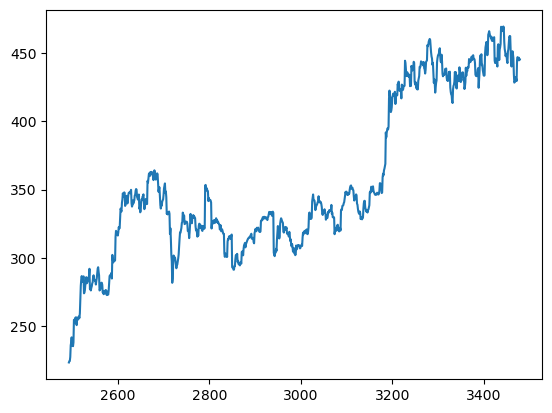

In [109]:
plt.plot(df["Close"])
#df.tail()
df.head()

In [110]:
## Testing Values
# 2.0 For Longing and -2.0 for Shorting
df["Confl_Strategy"].value_counts()

## Posssible Changes to make more trades and more return:

    # RSI 30-70 --> RSI 40-6: more trades, more return
    # df["MACD_HIST"] > 0 --> df["MACD_HIST"] < 0: 
    # Daily Data --> Hourly Data
    # Change the Ticket

## At 10000 Days, the returns increase, even if below the Buy&Hold
# One could leverage it 


Confl_Strategy
 1.0    386
-1.0    241
-2.0    222
 2.0    118
 0.0     19
Name: count, dtype: int64